Lecture: AI I - Advanced 

Previous:
[**Chapter 1.2: Multilayer Perceptron**](../02_mlp.ipynb)

---

# Exercise 1.2: Multilayer Perceptron

> Hint: When doing the exercises put your solution in the designated "Solution" section:
> ```python
> # Solution (put your code here)
> ```

## Task 1: Diabetes Regression with Multi-Layer Perceptron

The diabetes dataset contains 442 samples with 10 baseline variables (age, sex, BMI, blood pressure, and 6 blood serum measurements). The target is a quantitative measure of disease progression one year after baseline.

**Tasks**
- Data Exploration & Understanding
- Data preparation
- Build Model a Multi-Layer Perceptron for regression
- Train the model 
- Evaluate the model performance using appropriate regression metrics (e.g. MSE, MAE) and Tensorboard

In [21]:
# prerequisites (don't edit this block)
from sklearn.datasets import load_diabetes
import torch

diabetes = load_diabetes()
x = diabetes.data
y = diabetes.target

n = 442
x = torch.tensor(x, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1,1)

x = (x - x.mean(dim=0, keepdim=True) / (x.std(dim=0, keepdim=True) + 1e-7))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

class RegressionMLP(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 1)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x) 
        return x

In [23]:
from datetime import datetime

from torch.utils.data import TensorDataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter(log_dir=f'./data/02_mlp/runs/run_{datetime.now().strftime("%Y%m%d-%H%M%S")}')

#x_norm = (x - x.mean(dim=0, keepdim=True)) / x.std(dim=0, keepdim=True)
ids = torch.randperm(len(x))
train_ids = ids[:int(n * .6)]
val_ids = ids[int(n * .6):int(n * .8)]
test_ids = ids[int(n * .8):]

train_dataset = TensorDataset(x[train_ids], y[train_ids])
val_dataset = TensorDataset(x[val_ids], y[val_ids])
test_dataset = TensorDataset(x[test_ids], y[test_ids])

batch_size = 32
train_loader = DataLoader(
    train_dataset, 
    batch_size=batch_size, 
    shuffle=True  # Shuffle training data each epoch
)
val_loader = DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle validation
)

test_loader = DataLoader(
    test_dataset, 
    batch_size=batch_size, 
    shuffle=False  # Don't shuffle test
)

print(f"Training batches per epoch: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches per epoch: 9
Validation batches: 3
Test batches: 3


In [24]:
model = RegressionMLP(input_dim=10)

# Log the model architecture to TensorBoard
writer.add_graph(model, x[train_ids][:batch_size])

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Architecture:")
print(model)
print(f"\nTotal parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")

Model Architecture:
RegressionMLP(
  (fc1): Linear(in_features=10, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=1, bias=True)
)

Total parameters: 2,817
Trainable parameters: 2,817


In [25]:
import numpy as np

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.01) # sollen wir standardmäßig als Optimizer verwenden
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, 
    mode='min',      # Reduce LR when validation loss stops decreasing
    factor=0.5,      # Multiply LR by 0.5
    patience=10,     # Wait 10 epochs before reducing
)

def train_epoch(model, train_loader, criterion, optimizer):
    """Train for one epoch"""
    model.eval()  # Set model to training mode
    train_loss = 0.0
    
    for batch_X, batch_y in train_loader:
        # Forward pass
        predictions = model(batch_X)
        loss = criterion(predictions, batch_y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * batch_X.size(0)
    
    return train_loss / len(train_loader.dataset)  # Return average loss

def validate(model, val_loader, criterion):
    """Validate the model"""
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    
    with torch.no_grad():  # Disable gradient computation for efficiency
        for batch_X, batch_y in val_loader:
            predictions = model(batch_X)
            loss = criterion(predictions, batch_y)
            val_loss += loss.item() * batch_X.size(0)
    
    return val_loss / len(val_loader.dataset)

def compute_metrics(model, data_loader):
    """Compute detailed regression metrics"""
    model.eval()
    all_predictions = []
    all_targets = []
    
    with torch.no_grad():
        for batch_X, batch_y in data_loader:
            predictions = model(batch_X)
            all_predictions.append(predictions)
            all_targets.append(batch_y)
    
    predictions = torch.cat(all_predictions, dim=0)
    targets = torch.cat(all_targets, dim=0)
    
    mse = F.mse_loss(predictions, targets).item()        
    return {
        'mse': mse,                                     # Mean Squared Error (MSE)
        'rmse': np.sqrt(mse),                           # Root Mean Squared Error (RMSE)
        'mae': F.l1_loss(predictions, targets).item(),  # Mean Absolute Error (MAE)
    }

# Training loop
num_epochs = 100
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
early_stopping_patience = 20

for epoch in range(num_epochs):
    # Train
    train_loss = train_epoch(model, train_loader, criterion, optimizer)
    train_losses.append(train_loss)

    # Validate
    val_loss = validate(model, val_loader, criterion)
    val_losses.append(val_loss)

    # Log losses to TensorBoard
    writer.add_scalar('Loss/Train', train_loss, epoch)
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    writer.add_scalars('Loss/Train_vs_Val', {'Train': train_loss, 'Validation': val_loss}, epoch)

    # Update learning rate based on validation loss
    scheduler.step(val_loss)

    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

        torch.save(model.state_dict(), './data/02_mlp/model.pth')  # Save best model
    else:
        patience_counter += 1

    if (epoch + 1) % 10 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:3d}/{num_epochs} | "
              f"Train Loss: {train_loss:7.4f} | "
              f"Val Loss: {val_loss:7.4f} | "
              f"LR: {optimizer.param_groups[0]['lr']:.6f}")
        
    if patience_counter >= early_stopping_patience:
        print(f"\nEarly stopping triggered after {epoch+1} epochs")
        break

writer.close()

Epoch   1/100 | Train Loss: 28438.3163 | Val Loss: 29056.8159 | LR: 0.001000


Epoch  10/100 | Train Loss: 27384.9246 | Val Loss: 27836.9535 | LR: 0.001000
Epoch  20/100 | Train Loss: 21518.5748 | Val Loss: 21380.8351 | LR: 0.001000
Epoch  30/100 | Train Loss: 10595.2414 | Val Loss: 10019.9873 | LR: 0.001000
Epoch  40/100 | Train Loss: 4578.5488 | Val Loss: 4159.3068 | LR: 0.001000
Epoch  50/100 | Train Loss: 3983.7517 | Val Loss: 3567.2010 | LR: 0.001000
Epoch  60/100 | Train Loss: 3737.4518 | Val Loss: 3363.4284 | LR: 0.001000
Epoch  70/100 | Train Loss: 3540.9734 | Val Loss: 3226.0638 | LR: 0.001000
Epoch  80/100 | Train Loss: 3381.0281 | Val Loss: 3117.9504 | LR: 0.001000
Epoch  90/100 | Train Loss: 3253.2331 | Val Loss: 3064.5695 | LR: 0.001000
Epoch 100/100 | Train Loss: 3137.5762 | Val Loss: 3018.8360 | LR: 0.001000


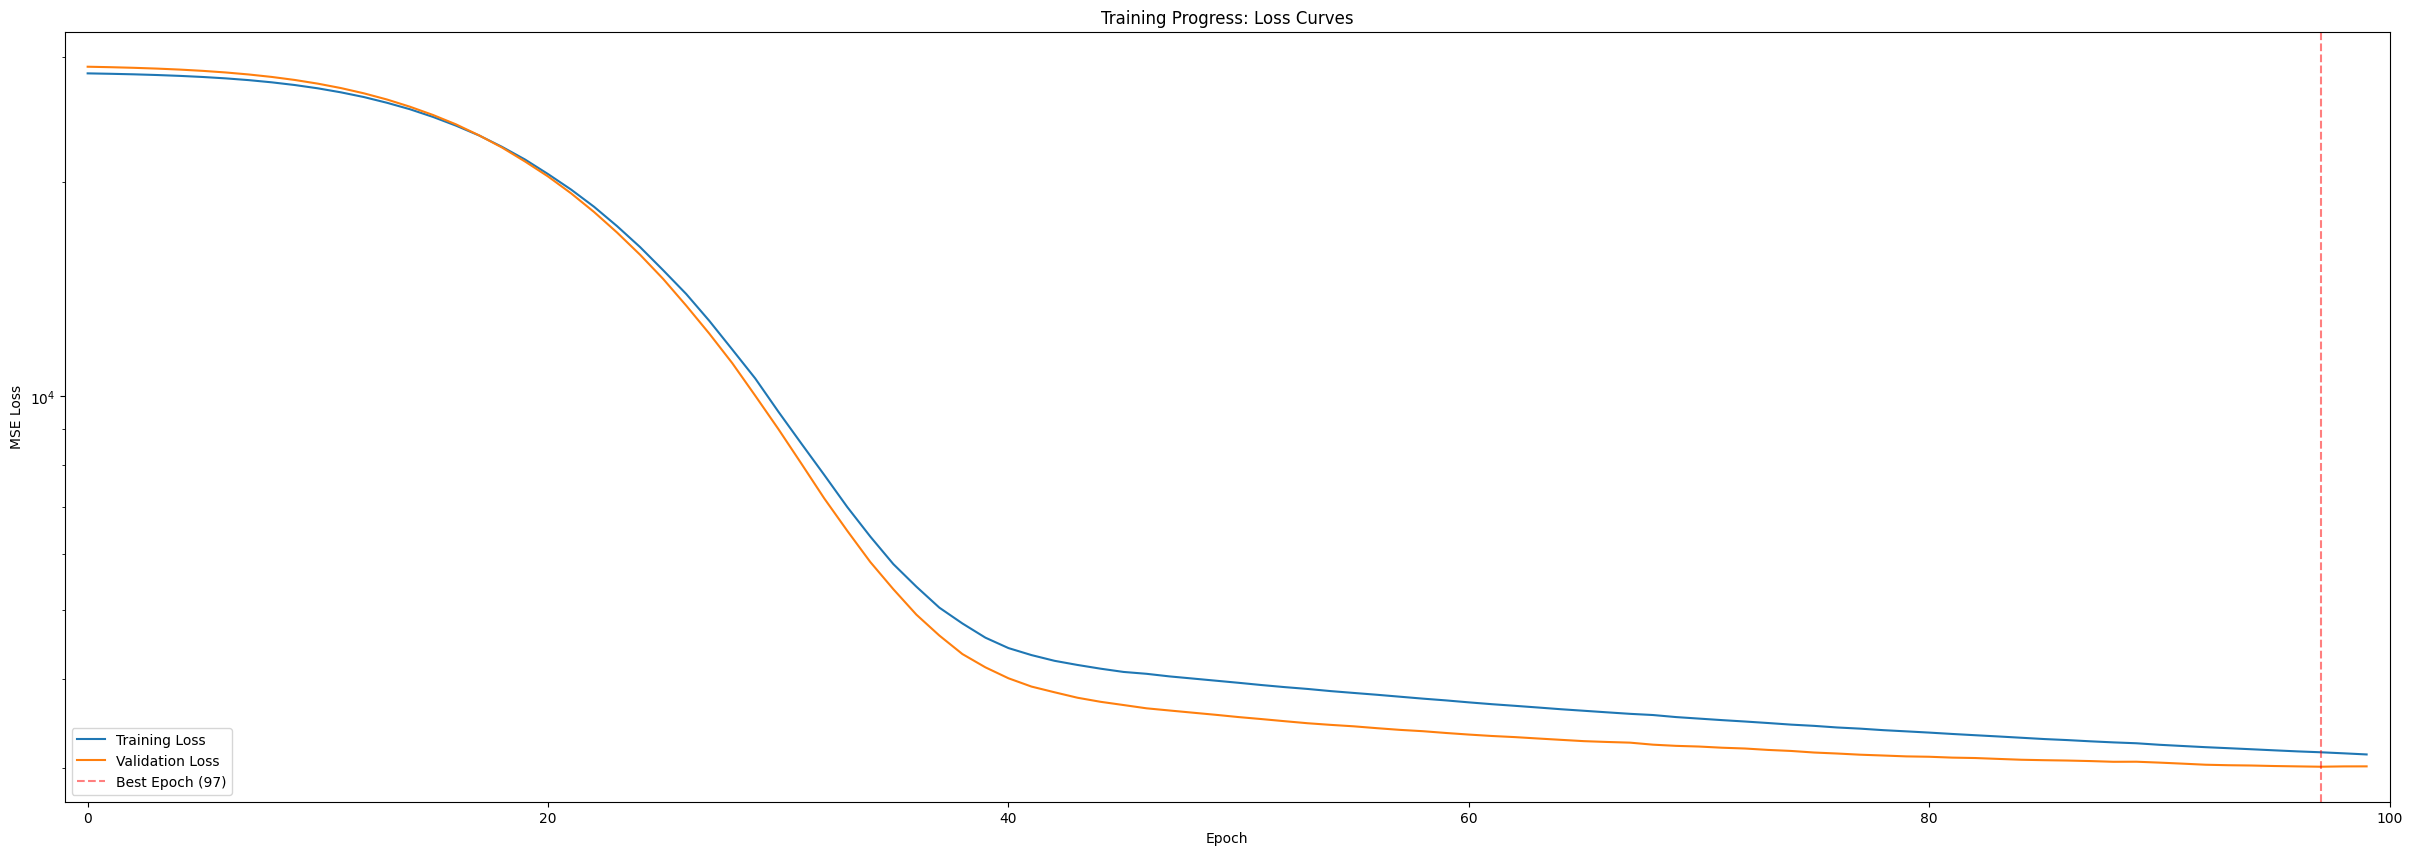

In [26]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(30, 10))
ax.plot(train_losses, label='Training Loss')
ax.plot(val_losses, label='Validation Loss')
ax.set(xlabel='Epoch', ylabel='MSE Loss', title='Training Progress: Loss Curves', yscale='log', xlim=(-1, len(train_losses)))

# Mark best epoch
best_epoch = np.argmin(val_losses)
ax.axvline(x=best_epoch, color='red', linestyle='--', alpha=0.5, label=f'Best Epoch ({best_epoch})')

ax.legend()

In [27]:
model.load_state_dict(torch.load('./data/02_mlp/model.pth'))

train_metrics = compute_metrics(model, train_loader)
val_metrics = compute_metrics(model, val_loader)
test_metrics = compute_metrics(model, test_loader)  # Compute test metrics
print(f"MSE:  {test_metrics['mse']:.4f}")
print(f"RMSE: {test_metrics['rmse']:.4f} (± ${test_metrics['rmse']:.2f}k average error)")
print(f"MAE:  {test_metrics['mae']:.4f} (${test_metrics['mae']:.2f}k average error)")

MSE:  3503.2854
RMSE: 59.1886 (± $59.19k average error)
MAE:  49.1076 ($49.11k average error)


In [28]:
y[test_ids].flatten().shape, model(x[test_ids]).flatten().shape

(torch.Size([89]), torch.Size([89]))

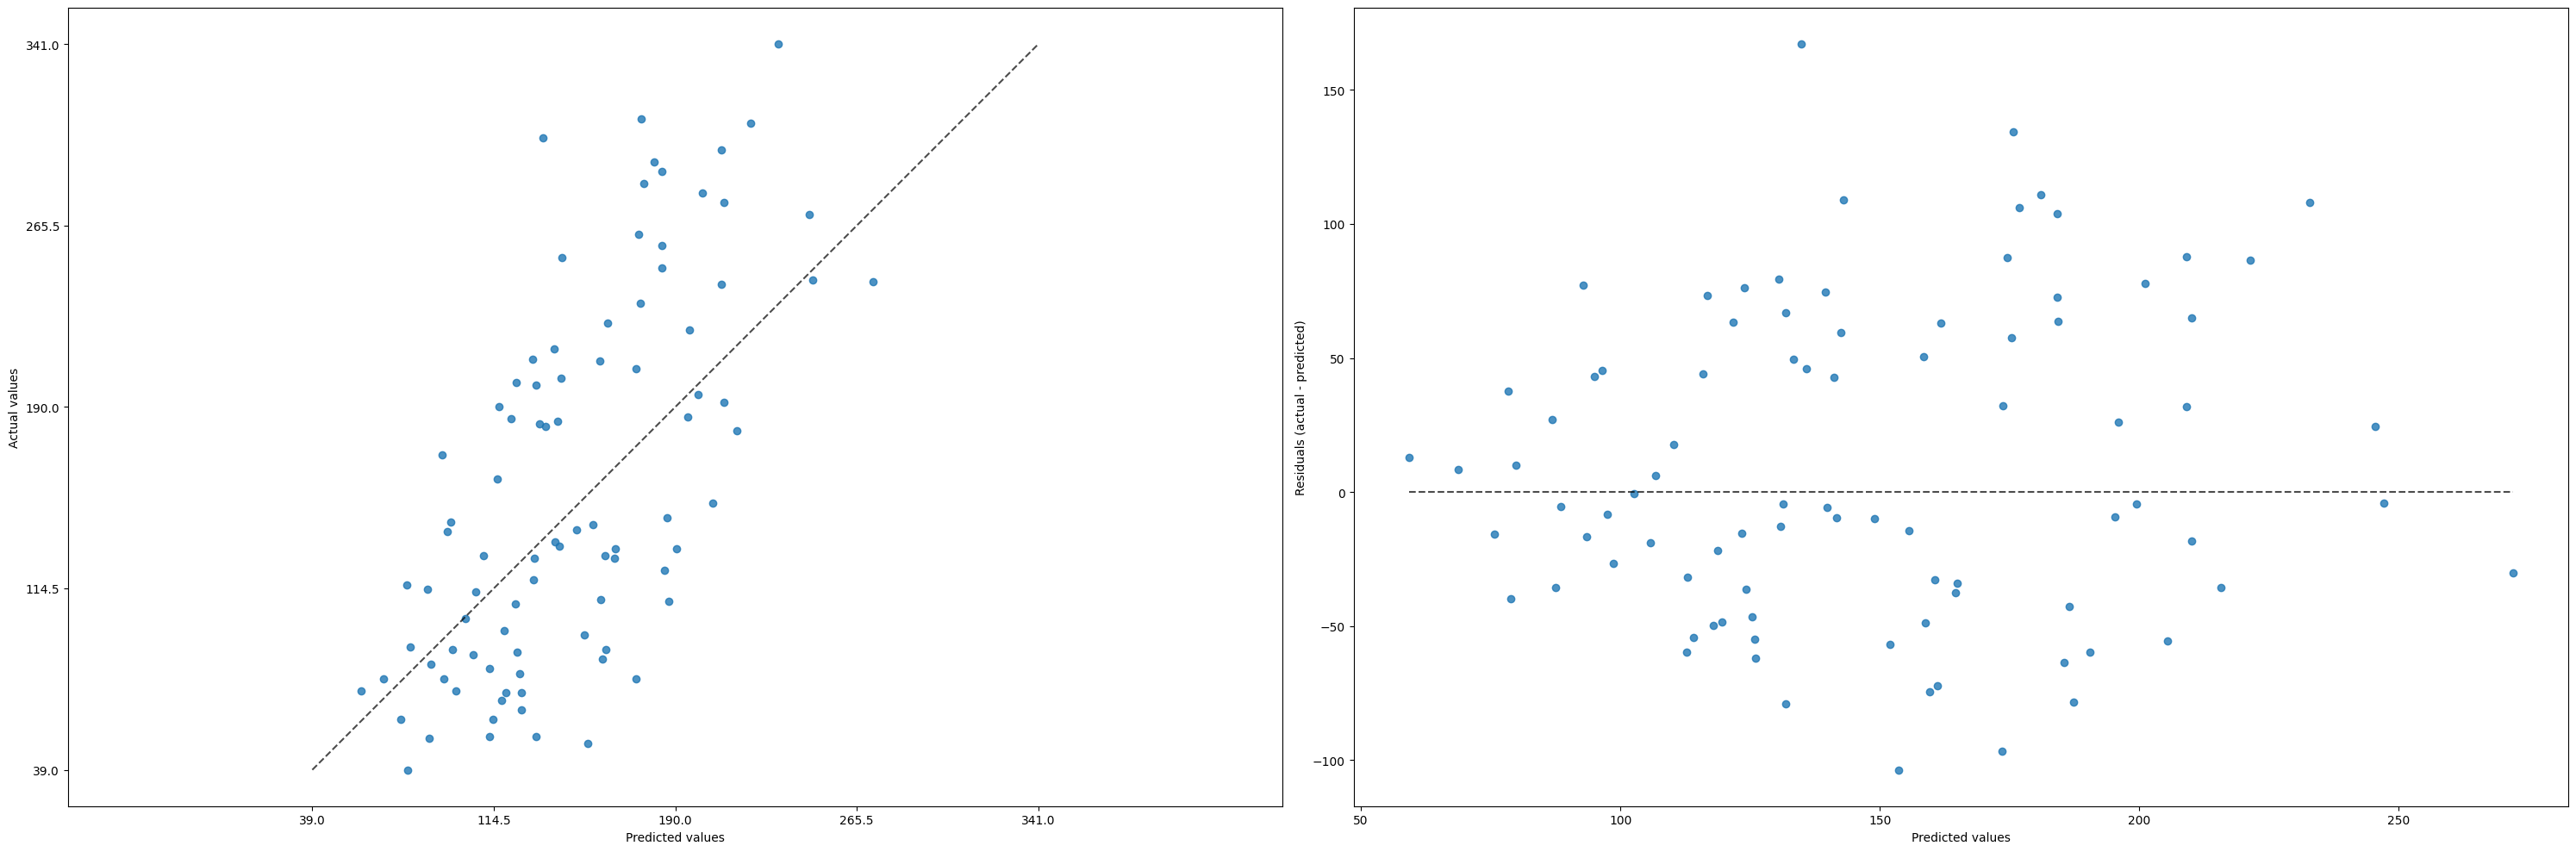

In [29]:
from sklearn.metrics import PredictionErrorDisplay

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 10))

y_true = y[test_ids].numpy().ravel()
y_pred = model(x[test_ids]).detach().numpy().ravel()

PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    ax=ax1,
    kind='actual_vs_predicted',
)
PredictionErrorDisplay.from_predictions(
    y_true,
    y_pred,
    kind='residual_vs_predicted',
    ax=ax2,
)
fig.tight_layout()

In [30]:
# Test case (don't edit this block)
assert True

---

Lecture: AI I - Advanced 

Next: [**Chapter 2.1: Regularization**](../../02_training/01_regularization.ipynb)